# Introduction

In this competition a significant delta between local CV and LB scores has been reported in some cases (https://www.kaggle.com/c/trends-assessment-prediction/discussion/153256). We have many features to work with... maybe too many. Reducing variance would seem to be a good thing here and I wanted to investigate the BaggingRegressor for that. The idea is to use the BaggingRegressor to build multiple models, each considering only a fraction of the features, then combine their outputs. From the scikit-learn docs:

"A Bagging regressor is an ensemble meta-estimator that fits base regressors each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it."

Ridge regression is known to work well on this dataset, so is used as the base regressor here. The use of the BaggingRegressor is considered as part of a high-performing ensemble, combining SVM and Ridge regression.

This notebook is heavily based on @aerdem4's excellent SVM notebook and @tunguz's notebook that adds Ridge regression. Those original notebooks can be found here:
https://www.kaggle.com/aerdem4/rapids-svm-on-trends-neuroimaging
https://www.kaggle.com/tunguz/rapids-ensemble-for-trends-neuroimaging/

## Results

After doing an offline sweep of blending weights, the final weights show that for the best local CV, the BaggingRegressor was hardly used for the "age" target. However, the BaggingRegressor provided more benefits for the domain variables. In particular for "domain1_var2" and "domain2_var2" the BaggingRegressor almost completely replaces the basic Ridge regression method.

In terms of local CV, the result is almost identical to Bojan's notebook referenced above. On the leaderboard, adding the BaggingRegressor into the ensemble scores 0.1593, an improvement over Bojan's 0.1595. So the local CV to LB delta is successfully reduced, albeit by a little.

I find it particularly interesting that only considering small subsets of the features, the BaggingRegressor is competitive for the domain variables but not at all for age.


# Load the data

In [19]:
import numpy as np
import pandas as pd
import argparse
import warnings
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm.notebook as tqdm

def metric(y_true, y_pred):
    return np.mean(np.sum(np.abs(y_true - y_pred), axis=0)/np.sum(y_true, axis=0))

In [4]:
# parser = argparse.ArgumentParser()
# parser.add_argument(
#     "-tid", "--target_id", type=int, default=0,
#     help="target_id (default=0)")
# parser.add_argument(
#     "-f", "--feature_names", type=int, default=0)

# args = parser.parse_args()
# target_id = args.target_id
# feature_names = args.feature_names
feature_names = 1

target_id = 2
targets = ["age", "domain1_var1", "domain1_var2", "domain2_var1", "domain2_var2"]
target = targets[target_id]
weights = [0.3, 0.175, 0.175, 0.175, 0.175]
weight = weights[target_id]
best_alpha = [0.00026, 0.0041, 0.0041, 0.00205, 0.00205]
alpha = best_alpha[target_id]
print(target, weight, "feature_names:", feature_names, "alpha:", alpha)
fnc_df = pd.read_csv("../input/trends-assessment-prediction/fnc.csv")
loading_df = pd.read_csv("../input/trends-assessment-prediction/loading.csv")

fnc_features, loading_features = list(fnc_df.columns[1:]), list(loading_df.columns[1:])
df = fnc_df.merge(loading_df, on="Id")


labels_df = pd.read_csv("../input/trends-assessment-prediction/train_scores.csv")
labels_df["is_train"] = True

df = df.merge(labels_df, on="Id", how="left")

test_df = df[df["is_train"] != True].copy()
df = df[df["is_train"] == True].copy()

domain1_var2 0.175 feature_names 1 alpha: 0.0041


In [3]:
# Giving less importance to FNC features since they are easier to overfit due to high dimensionality.
FNC_SCALE = 1/600

df[fnc_features] *= FNC_SCALE
test_df[fnc_features] *= FNC_SCALE

In [18]:
# To check the best alpha
df_model = df.copy()
max_iter = 1403
NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=2020)

features = loading_features + fnc_features
max_features = len(features)

ridge_beta = pd.DataFrame(np.zeros((max_iter, max_features + 1)), columns=features + ["intercept_"])

y_oof = np.zeros((df.shape[0], max_iter))
y_preds = np.zeros((NUM_FOLDS, max_iter, df.shape[0]))
y_scores = np.zeros((max_iter, NUM_FOLDS))
scores = np.zeros(max_iter)  

for f, (train_ind, val_ind) in enumerate(tqdm(kf.split(df, df))):
    for i in range(max_iter):
        _features = features[:max_features - i]
        train_df, val_df = df.iloc[train_ind], df.iloc[val_ind]
        train_df = train_df[train_df[target].notnull()]

        model = Ridge(alpha=alpha)
        model.fit(train_df[_features].values, train_df[target].values)

        val_pred = model.predict(val_df[_features])
        y_preds[f, i] = model.predict(test_df[_features])
        
        y_oof[val_ind, i] = val_pred
        null_idx = val_df[target].notnull()
        y_scores[i, f] = metric(val_df[target][null_idx].values, val_pred[null_idx]) * weight
        if f == 0:
            ridge_beta[_features].iloc[i] = model.coef_
            ridge_beta["intercept_"].iloc[i] = model.intercept_    


KeyboardInterrupt: 

In [ ]:
ridge_beta
ridge_beta.to_csv(f"ridge_results/pred_{target}_No{feature_names}_CV.csv", index=False)

In [76]:
for i in range(max_iter):
    null_idx = df[target].notnull().values
    y_oof_not_null = y_oof[null_idx, i]
    y_true = df[null_idx][target].values
    scores[i] = metric(y_oof_not_null, y_true) * weight

best score CV:0.02640, alhpa:0.00410 in domain1_var1


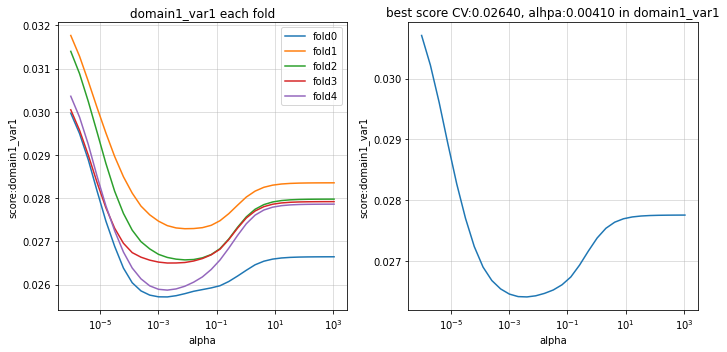

In [77]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
for f in range(NUM_FOLDS):
    plt.plot(alphas, y_scores[:, f], label=f"fold{f}")
plt.legend()
plt.xlabel('n_feature')
plt.ylabel(f'score:{target}')
plt.grid(alpha=0.5)
plt.title(f'No:{feature_names}, {target} each fold')
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(alphas, scores)
plt.xlabel('n_feature')
plt.ylabel(f'score:{target}')
plt.grid(alpha=0.5)
best_idx = np.where(scores == scores.min())[0][0]
plt.title(f'best score CV:{scores[best_idx]:.5f}, n_feature:{alphas[best_idx]:.5f} in {target}')
plt.tight_layout()
plt.savefig(f"ridge_results/{target}_No{feature_names}_CV.png")

print(f'best score CV:{scores[best_idx]:.5f}, n_feature:{alphas[best_idx]:.5f} in {target}')
valid_df = pd.DataFrame(np.zeros((df.shape[0], 2)), columns=["Id", f"{target}_pred"])
valid_df['Id'] = df.Id
valid_df[f"{target}_pred"] = y_oof[:, best_idx]
valid_df.to_csv(f"ridge_results/val_{target}_No{feature_names}_CV.csv", index=False)
pred_df = pd.DataFrame(np.zeros((test_df.shape[0], 2)), columns=["Id", f"{target}_pred"])
pred_df['Id'] = test_df.Id
pred_df[f"{target}_pred"] = y_preds.mean(axis=0)[best_idx]
pred_df.to_csv(f"ridge_results/pred_{target}_No{feature_names}_CV.csv", index=False)